In [1]:
import math
import os
from pathlib import Path
import sys
sys.path.insert(0, '..')
import pandas as pd
import matplotlib.pyplot as plt
import energy_flexibility_kpis.kpi.energy_flexibility.demand_profile_reshaping as demand_profile_reshaping
import energy_flexibility_kpis.kpi.energy_flexibility.demand_response_costs_or_savings as demand_response_costs_or_savings
import energy_flexibility_kpis.kpi.energy_flexibility.demand_response_emission_or_environmental_impact as demand_response_emission_or_environmental_impact
import energy_flexibility_kpis.kpi.energy_flexibility.demand_response_energy_efficiency as demand_response_energy_efficiency
import energy_flexibility_kpis.kpi.energy_flexibility.energy_or_average_power_load_shedding as energy_or_average_power_load_shedding
import energy_flexibility_kpis.kpi.energy_flexibility.energy_storage_capability as energy_storage_capability
import energy_flexibility_kpis.kpi.energy_flexibility.grid_interaction as grid_interaction
import energy_flexibility_kpis.kpi.energy_flexibility.impact_on_ieq as impact_on_ieq
import energy_flexibility_kpis.kpi.energy_flexibility.load_shifting as load_shifting
import energy_flexibility_kpis.kpi.energy_flexibility.peak_power_or_energy_rebound as peak_power_or_energy_rebound
import energy_flexibility_kpis.kpi.energy_flexibility.peak_power_shedding as peak_power_shedding
import energy_flexibility_kpis.kpi.energy_flexibility.valley_filling as valley_filling
from energy_flexibility_kpis.utilities import FileHandler

# Package File Structure
---

In [2]:
!tree ../energy_flexibility_kpis -P '*.py' -I '__pycache__'

Too many parameters - -P


# How to get the info for a KPI
---

In [3]:
peak_power_or_energy_rebound.PeakPowerRebound.info()
#peak_power_shedding.PeakPowerReduction.info()["name"]

{'name': 'peak power rebound',
 'definition': 'Power demand increase during peak hour after flexible operation (rebound effect). The evaluation window should be set to the rebound period.',
 'unit': 'kW',
 'category': 'EF KPI: Peak Power/Energy Rebound',
 'relevance': 3,
 'stakeholders': ['distribution system operator',
  'transmisssion system operator'],
 'complexity': 1,
 'need_baseline': True,
 'temporal_evaluation_window': 'single event',
 'temporal_resolution': 'unspecified',
 'spatial_resolution': 'single building',
 'doe_flexibility_category': ['load shifting', 'load shedding'],
 'performance_aspect': ['power'],
 'calculation_arguments': [{'name': 'baseline electric power profile',
   'snake_case_name': 'baseline_electric_power_profile',
   'definition': 'A time series data points of electric power demand acquired in baseline operation scenario.',
   'primitive_type': {'name': 'power demand',
    'definition': 'An instantaneous power demand of a entity at a moment.',
    'unit':

# KPI Calculation Function Design Choices
---
1. All KPIs have a `calculate` function whose arguments refer to the variables listed in the [variables sheet](https://docs.google.com/spreadsheets/d/1tSN3PIu-lh9aSiU775-RULTRy2o2owIzV-iwymNXszo/edit#gid=118080661).
2. Every KPIs `calculate` function has positional arguments that must be provided and keyword arguments that are optional. The positional arguments will typically include power and energy profile e.g., `generic_electric_power_profile`, `flexible_electric_power_profile`, e.t.c. In some cases, `timestamps` variable is required e.g. in `energy_or_average_power_load_shedding.AnnualAverageDailyLoadVariation` where `timestamps` variable is needed to infer `hour-of-day` and `day-of-year` variables.
1. Every KPI's `calculate` function has `timestamps`, `evaluation_start_timestamp` and `evaluation_end_timestamp` as optional arguments so that the user can at any time supply the full power or energy profile and only need to control the `evaluation_start_timestamp` and `evaluation_end_timestamp` variables to consider specific time periods during calculation.
2. `timestamps` can be a datetime series of a timestep series i.e. integers.
3. KPIs that are defined for a building or DER cluster will take in a list of lists for some variables instead of taking in a single list of values
4. Writing all KPIs with the assumption that the input variables are in SI unit and values are reported as such eg. time in seconds, power in kW, energy in kWh.

# User input (config file)
---

In [4]:
config_path = 'config_file_multizone_office_simple_air.yaml'

In [5]:
import yaml
import pandas as pd

# Load the YAML file
with open(config_path, 'r') as file:
    data = yaml.safe_load(file)

# Access the data
database_file_name = data['database_file_name']

path_to_dataset = data['path_to_dataset']
brick_model_file_name = data['brick_model_file_name']
updated_brick_model_file_name = data['updated_brick_model_file_name']
price_signal_file_name = data['price_signal_file_name']

baseline_scenario = data['baseline_scenario']
flexible_scenario = data['flexible_scenario']

# Convert timestamp strings to pandas Timestamp objects
evaluation_timestamps = (
    pd.Timestamp(data['evaluation_timestamps']['start']),
    pd.Timestamp(data['evaluation_timestamps']['end'])
)

bldg_identifier = data['bldg_identifier']
timestamp_identifier = data['timestamp_identifier']
price_signal_identifier = data['price_signal_identifier']
shift_window = data['shift_window']
rebound_window = data['rebound_window']

# Now you can use the variables as needed in your code


In [6]:
import yaml

def validate_yaml(data):
    required_keys = [
        'path_to_dataset',
        'brick_model_file_name',
        'database_file_name',
        'updated_brick_model_file_name',
        'price_signal_file_name',
        'baseline_scenario',
        'flexible_scenario',
        'evaluation_timestamps',
        'bldg_identifier',
        'timestamp_identifier',
        'price_signal_identifier',
        'shift_window',
        'rebound_window'
    ]

    for key in required_keys:
        if key not in data:
            return False, f"Key '{key}' is missing in the YAML file."

    # Additional validation logic can be added here

    return True, "YAML file is valid."

# Load the YAML file
with open(config_path, 'r') as file:
    data = yaml.safe_load(file)

# Validate the YAML file
is_valid, message = validate_yaml(data)

# Print the validation result
if is_valid:
    print(message)
else:
    print(f"Validation failed: {message}")


YAML file is valid.


# Validating a Dataset

In [7]:
data_directory = Path(path_to_dataset)
print(data_directory)

..\data\boptest_dataset\stra_zone_temp_shed_ratchet_price\scenario1\multizone_office_simple_air


### Validating a Brick model

In [8]:
# Define manifest paths (metadata requirements for the KPIs)
manifest_paths = {'average demand decrease index':'validation_buildingMOTIF/manifests_kpis/manifest_average_demand_decrease_index.ttl',
                  'average demand decrease':'validation_buildingMOTIF/manifests_kpis/manifest_average_demand_decrease.ttl',
                  'average demand decrease intensity':'validation_buildingMOTIF/manifests_kpis/manifest_average_demand_decrease_intensity.ttl',
                  'average demand increase index':'validation_buildingMOTIF/manifests_kpis/manifest_average_demand_increase_index.ttl',
                  'average demand increase':'validation_buildingMOTIF/manifests_kpis/manifest_average_demand_increase.ttl',
                  'average demand increase intensity':'validation_buildingMOTIF/manifests_kpis/manifest_average_demand_increase_intensity.ttl',
                  'average power rebound index':'validation_buildingMOTIF/manifests_kpis/manifest_average_power_rebound_index.ttl',
                  'average power rebound':'validation_buildingMOTIF/manifests_kpis/manifest_average_power_rebound.ttl',
                  'energy savings of demand response':'validation_buildingMOTIF/manifests_kpis/manifest_energy_savings_of_demand_response.ttl',
                  'flexibility savings index':'validation_buildingMOTIF/manifests_kpis/manifest_flexibility_savings_index.ttl',
                  'net building consumption change percentage':'validation_buildingMOTIF/manifests_kpis/manifest_net_building_consumption_change_percentage.ttl',
                  'peak power reduction':'validation_buildingMOTIF/manifests_kpis/manifest_peak_power_reduction.ttl'
                  }


In [9]:
from validation_buildingMOTIF.kpis_validation import ValidationInterface

# Initialize validation interface
validator = ValidationInterface(os.path.join(data_directory,brick_model_file_name), manifest_paths)

# Run validation
suitable_kpis = []
suitable_kpis = validator.validate()
suitable_kpis = [list(d)[0] for d in suitable_kpis]

print(suitable_kpis)

 For KPI average demand decrease intensity - urn:bldg/Building needs between 1 and None uses of path https://brickschema.org/schema/Brick#area
 For KPI average demand increase intensity - urn:bldg/Building needs between 1 and None uses of path https://brickschema.org/schema/Brick#area
╒════════════════════════════════════════════╤═════════════════════╕
│ KPI                                        │ Validation Result   │
╞════════════════════════════════════════════╪═════════════════════╡
│ average demand decrease index              │ True                │
├────────────────────────────────────────────┼─────────────────────┤
│ average demand decrease                    │ True                │
├────────────────────────────────────────────┼─────────────────────┤
│ average demand decrease intensity          │ False               │
├────────────────────────────────────────────┼─────────────────────┤
│ average demand increase index              │ True                │
├───────────────────────

### Validating a Config file

In [ ]:
import yaml
import pandas as pd

# Define the dictionary of KPIs and their required keys
kpi_required_keys = {
    'average demand decrease': [
        'baseline_scenario',
        'flexible_scenario',
        'evaluation_timestamps',
        'bldg_identifier',
        'timestamp_identifier'
        ],
    'average power rebound': [
        'price_signal_file_name',
        'baseline_scenario',
        'flexible_scenario',
        'evaluation_timestamps',
        'bldg_identifier',
        'timestamp_identifier',
        'price_signal_identifier',
        'rebound_window'
        ],
    # Add more KPIs and their required keys as needed
}

def validate_yaml(data, kpi_name):
    # Get the required keys for the specified KPI
    required_keys = kpi_required_keys.get(kpi_name, [])

    for key in required_keys:
        if key not in data:
            return False, f"Key '{key}' is missing for KPI '{kpi_name}' in the YAML file."

    # Additional validation logic can be added here

    return True, f"KPI '{kpi_name}' is valid."

# Load the YAML file
with open(config_path, 'r') as file:
    data = yaml.safe_load(file)

# Specify the list of KPIs you want to validate
kpis_to_validate = ['average demand decrease', 'average demand increase']  # Add more KPIs as needed

# Validate the YAML file for each specified KPI
for kpi_to_validate in kpis_to_validate:
    is_valid, message = validate_yaml(data, kpi_to_validate)

# Print the validation result
if is_valid:
    print(message)
else:
    print(f"Validation failed: {message}")


KPI 'average power rebound' is valid.


# Importing a Dataset
---

### Edit Brick model 
Include references to csv files per datapoint

In [10]:
import duckdb
import pandas as pd
import glob
import rdflib
from pathlib import Path
from rdflib import Namespace, Literal, Graph, BNode
from rdflib import RDF, RDFS, BRICK

A = RDF.type
REF = Namespace("https://brickschema.org/schema/Brick/ref#")
BLDG = Namespace("urn:boptest_example/")

model = Graph()
model.bind("ref", REF)
model.bind("rdfs", RDFS)
model.bind("brick", BRICK)
model.bind("bldg", BLDG)

# load base model from file
model.parse(os.path.join(data_directory,brick_model_file_name))

db = duckdb.connect(database_file_name)

# load in the CSV files
for filename in glob.glob(os.path.join(data_directory, "*.csv")):
    print(filename)
    table_name = Path(filename).name.split('.')[0]
    df = pd.read_csv(filename, skiprows=[1])
    df['Timestamp'] = pd.to_datetime(df.pop(timestamp_identifier))
    # remove first row -- it is the unit declarations
    df.drop(1, axis=0)
    db.execute(f"DROP TABLE IF EXISTS {table_name}")

    db.execute(f"CREATE TABLE {table_name} AS SELECT * FROM df")

    # add the annotation to the Brick model
    for pointlabel in df.columns:
        point = list(model.query(f'SELECT ?point WHERE {{ ?point ref:hasExternalReference ?ref . ?ref ref:hasTimeseriesId "{pointlabel}" }}'))

        if not point:
            continue
        point = point[0][0]
        reference = BNode()
        model.add((point, REF.hasExternalReference, reference))
        model.add((reference, A, REF.TimeseriesReference))
        model.add((reference, REF.hasTimeseriesId, Literal(pointlabel)))
        model.add((reference, REF.onTable, Literal(table_name)))
        model.add((reference, REF.storedAt, Literal("data.db")))
model.serialize(os.path.join(data_directory,updated_brick_model_file_name))
# save data to duckdb
db.commit()

..\data\boptest_dataset\stra_zone_temp_shed_ratchet_price\scenario1\multizone_office_simple_air\baseline_dataset.csv
..\data\boptest_dataset\stra_zone_temp_shed_ratchet_price\scenario1\multizone_office_simple_air\baseline_powerData.csv
..\data\boptest_dataset\stra_zone_temp_shed_ratchet_price\scenario1\multizone_office_simple_air\electricity_prices_highly_dynamic.csv
..\data\boptest_dataset\stra_zone_temp_shed_ratchet_price\scenario1\multizone_office_simple_air\flexible_dataset.csv
..\data\boptest_dataset\stra_zone_temp_shed_ratchet_price\scenario1\multizone_office_simple_air\flexible_powerData.csv
..\data\boptest_dataset\stra_zone_temp_shed_ratchet_price\scenario1\multizone_office_simple_air\prices.csv


# Map Dataset to EFONT Variables
---

In [11]:
# Parse graph
g = rdflib.Graph()
g.parse(os.path.join(data_directory,updated_brick_model_file_name))
# Establish a connection to DuckDB database
db = duckdb.connect(database=database_file_name)

scenarios = {
    baseline_scenario: 'baseline_',
    flexible_scenario: 'flexible_'
}

data_dict = {}

for scenario, column_name in scenarios.items():
    query = f"""
    PREFIX ref: <https://brickschema.org/schema/Brick/ref#>
    SELECT ?power_point WHERE {{
        ?point a brick:Electric_Power_Sensor ;
            ref:hasExternalReference ?ref .
        ?ref ref:onTable "{scenario}" ;
            ref:hasTimeseriesId ?power_point .

    }}"""

    # Convert the rows to a dictionary for DataFrame creation
    for row in g.query(query):
        #print(row)
        power_point = row [0]
        duck_query_label = f"SELECT Timestamp, {power_point} FROM {scenario}"
        
        res_label = db.execute(duck_query_label)
        timestamp_values_label = res_label.fetchall()
        #for row in timestamp_values_label[:5]:
        #    print(row)

        # Extract timestamps and values from the rows
        timestamps_label, values_label = zip(*timestamp_values_label)

        # Resample the values
        values_series_label = pd.Series(values_label, index=timestamps_label)
        
        resampled_series_label = values_series_label.resample('15T').mean()/1000

        # Create columns for label and sensor data for each scenario
        if f'{column_name}electric_power_profile' in data_dict:
            data_dict[f'{column_name}electric_power_profile'] += resampled_series_label
        else:
            data_dict[f'{column_name}electric_power_profile'] = resampled_series_label


# Create a DataFrame from the data dictionary
data = pd.DataFrame(data_dict)

# Reset the index to convert the timestamp index to a column
data = data.rename_axis('timestamp').reset_index()

# Print the DataFrame
display(data.head(81))


,timestamp,baseline_electric_power_profile,flexible_electric_power_profile
0,1970-01-20 00:00:00,0.001963,0.001963
1,1970-01-20 00:15:00,0.001974,0.001974
2,1970-01-20 00:30:00,0.001987,0.001987
3,1970-01-20 00:45:00,0.001998,0.001998
4,1970-01-20 01:00:00,0.002001,0.002001
...,...,...,...
76,1970-01-20 19:00:00,0.263769,0.494829
77,1970-01-20 19:15:00,0.001985,0.001980
78,1970-01-20 19:30:00,0.001985,0.001980
79,1970-01-20 19:45:00,0.001985,0.001980


In [12]:
def get_price_threshold(price_schedule): 
   
    # Sort the prices in ascending order
    price_schedule.sort()

    # Calculate the index of the third quartile
    n = len(price_schedule)
    k = (3.0 * n - 1) / 4

    # Determine the price threshold as the third quartile
    if k == int(k):
        priceThreshold = price_schedule[int(k) - 1]
    else:
        priceThreshold = (price_schedule[int(k) - 1] + price_schedule[int(k)]) / 2

    return priceThreshold

In [13]:
import pandas as pd

# Read the DataFrame from a CSV file
price_df = pd.read_csv(os.path.join(data_directory,price_signal_file_name))

# Extract the start and end times from the evaluation timestamp
start_time, end_time = evaluation_timestamps[0]

# Filter the DataFrame to include only rows within the specified time range
price_df[timestamp_identifier] = pd.to_datetime(price_df[timestamp_identifier])
filtered_price_df = price_df[(price_df[timestamp_identifier] >= start_time) & (price_df[timestamp_identifier] <= end_time)]
display(filtered_price_df.head(15))
price_values = filtered_price_df[price_signal_identifier].tolist()
print(price_values)
price_threshold = get_price_threshold(price_values)
print(price_threshold)

# Filter the rows where price_signal is greater than price_threshold
shed_price_df = filtered_price_df[filtered_price_df[price_signal_identifier] >= price_threshold]

# Print the DataFrame
display(shed_price_df.head(15))

shed_price_df[timestamp_identifier] = pd.to_datetime(shed_price_df[timestamp_identifier])
unique_dates = shed_price_df[timestamp_identifier].dt.strftime('%Y-%m-%d').unique()

# Create list of signal timestamps
signal_timestamps = []

for day in pd.date_range(start_time, end_time, freq='D'):
    matching_date = str(day.date())
    
    # Check if there are any rows in df where the date matches the current date
    if matching_date in unique_dates:
        group = shed_price_df[shed_price_df[timestamp_identifier].dt.date == day.date()]
        group['time'] = group['time'].dt.strftime('%H:%M:%S')  # Convert to string for comparison
        # Ensure the 'time' column is in datetime format
        group['time'] = pd.to_datetime(group['time'], format='%H:%M:%S')
        start_time = None

        for index, row in enumerate(group.itertuples()):
            if start_time is None:
                start_time = row.time
            elif row.time - group['time'].iloc[index - 1] != pd.Timedelta(minutes=1):
                end_time = group['time'].iloc[index - 1].replace(second=59, minute=59)
                signal_timestamps.append((pd.Timestamp(f"{matching_date} {start_time}").replace(tzinfo=None), pd.Timestamp(f"{matching_date} {end_time}").replace(tzinfo=None)))
                start_time = row.time

        if start_time is not None:
            end_time = group['time'].iloc[-1].replace(second=59, minute=59)
            signal_timestamps.append((pd.Timestamp(f"{matching_date} {start_time}").replace(tzinfo=None), pd.Timestamp(f"{matching_date} {end_time}").replace(tzinfo=None)))

# Display the result
print(signal_timestamps)

shed_signal_timestamps = []
if signal_timestamps:
    current_start, current_end = signal_timestamps[0]

    for start, end in signal_timestamps[1:]:
        if start <= current_end + pd.Timedelta(seconds=1):
            current_end = max(end, current_end)
        else:
            shed_signal_timestamps.append((current_start, current_end))
            current_start, current_end = start, end

    shed_signal_timestamps.append((current_start, current_end))

print(shed_signal_timestamps)

FileNotFoundError: [Errno 2] No such file or directory: '..\\data\\boptest_dataset\\stra_zone_temp_shed_ratchet_price\\scenario1\\multizone_office_simple_air\\scheduleData_dataset.csv'

In [ ]:

shed_price_df[timestamp_identifier] = pd.to_datetime(shed_price_df[timestamp_identifier])
price_df[timestamp_identifier] = pd.to_datetime(price_df[timestamp_identifier])

shift_timestamps = []
for index, row in shed_price_df.iterrows():
    end_time = row[timestamp_identifier]
    start_time = end_time - pd.Timedelta(hours=shift_window)
    shift_timestamp = price_df[(price_df[timestamp_identifier] >= start_time) & (price_df[timestamp_identifier] < end_time)]
    if not shift_timestamp.empty:
       shift_timestamps.append(shift_timestamp)

if shift_timestamps:
    shift_timestamps_df = pd.concat(shift_timestamps, ignore_index=True)

shift_price_df = shift_timestamps_df[shift_timestamps_df[price_signal_identifier] < price_threshold].drop_duplicates()

# Print the DataFrame
display(shift_price_df.head(10))

import pandas as pd

start_time, end_time = evaluation_timestamps[0]
shift_price_df[timestamp_identifier] = pd.to_datetime(shift_price_df[timestamp_identifier])
unique_dates = shift_price_df[timestamp_identifier].dt.strftime('%Y-%m-%d').unique()

# Create list of signal timestamps
signal_timestamps = []

for day in pd.date_range(start_time, end_time, freq='D'):
    matching_date = str(day.date())
    
    # Check if there are any rows in df where the date matches the current date
    if matching_date in unique_dates:
        group = shift_price_df[shift_price_df[timestamp_identifier].dt.date == day.date()]
        group['time'] = group['time'].dt.strftime('%H:%M:%S')  # Convert to string for comparison
        # Ensure the 'time' column is in datetime format
        group['time'] = pd.to_datetime(group['time'], format='%H:%M:%S')
        start_time = None

        for index, row in enumerate(group.itertuples()):
            if start_time is None:
                start_time = row.time
            elif row.time - group['time'].iloc[index - 1] != pd.Timedelta(minutes=1):
                end_time = group['time'].iloc[index - 1].replace(second=59, minute=59)
                signal_timestamps.append((pd.Timestamp(f"{matching_date} {start_time}").replace(tzinfo=None), pd.Timestamp(f"{matching_date} {end_time}").replace(tzinfo=None)))
                start_time = row.time

        if start_time is not None:
            end_time = group['time'].iloc[-1].replace(second=59, minute=59)
            signal_timestamps.append((pd.Timestamp(f"{matching_date} {start_time}").replace(tzinfo=None), pd.Timestamp(f"{matching_date} {end_time}").replace(tzinfo=None)))

# Display the result
print(signal_timestamps)

shift_signal_timestamps = []
if signal_timestamps:
    current_start, current_end = signal_timestamps[0]

    for start, end in signal_timestamps[1:]:
        if start <= current_end + pd.Timedelta(seconds=1):
            current_end = max(end, current_end)
        else:
            shift_signal_timestamps.append((current_start, current_end))
            current_start, current_end = start, end

    shift_signal_timestamps.append((current_start, current_end))

print(shift_signal_timestamps)


C:\Users\fafla\AppData\Local\Temp\ipykernel_27076\662206110.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shed_price_df[timestamp_identifier] = pd.to_datetime(shed_price_df[timestamp_identifier])


,time,InternalGainsRad[sou],InternalGainsCon[sou],InternalGainsLat[sou],InternalGainsRad[eas],InternalGainsCon[eas],InternalGainsLat[eas],InternalGainsRad[nor],InternalGainsCon[nor],InternalGainsLat[nor],...,cloTim,solZen,solAlt,solDec,solTim,solHouAng,TDryBul,TWetBul,PriceElectricPowerHighlyDynamic,PriceElectricPowerConstant
0,1970-01-20 17:00:00,1660.6400,1660.6400,830.3200,1051.32800,1051.32800,525.66400,1660.6400,1660.6400,830.3200,...,1702800,1.614314,-0.043517,-0.354479,1.702632e+06,120.677284,272.55,271.002071,0.06690,0.094
1,1970-01-20 18:00:00,913.3520,913.3520,456.6760,578.23040,578.23040,289.11520,913.3520,913.3520,456.6760,...,1706400,1.796207,-0.225411,-0.354331,1.706231e+06,120.939030,270.95,269.831050,0.07079,0.094
3,1970-01-20 20:00:00,149.4576,149.4576,74.7288,94.61952,94.61952,47.30976,149.4576,149.4576,74.7288,...,1713600,2.180975,-0.610179,-0.354032,1.713430e+06,121.462523,270.95,270.190466,0.07120,0.094
4,1970-01-21 06:00:00,83.0320,83.0320,41.5160,52.56640,52.56640,26.28320,83.0320,83.0320,41.5160,...,1749600,1.813115,-0.242319,-0.352530,1.749422e+06,124.079993,272.55,272.114052,0.05936,0.094
5,1970-01-21 07:00:00,83.0320,83.0320,41.5160,52.56640,52.56640,26.28320,83.0320,83.0320,41.5160,...,1753200,1.629856,-0.059059,-0.352379,1.753022e+06,124.341741,272.55,271.728477,0.06847,0.094
34,1970-01-25 04:00:00,83.0320,83.0320,41.5160,52.56640,52.56640,26.28320,83.0320,83.0320,41.5160,...,2088000,2.192907,-0.622111,-0.337542,2.087760e+06,148.684634,274.85,273.750187,0.06198,0.094
35,1970-01-25 05:00:00,83.0320,83.0320,41.5160,52.56640,52.56640,26.28320,83.0320,83.0320,41.5160,...,2091600,1.998477,-0.427680,-0.337375,2.091360e+06,148.946390,273.75,272.880625,0.06322,0.094
46,1970-01-25 15:00:00,1660.6400,1660.6400,830.3200,1051.32800,1051.32800,525.66400,1660.6400,1660.6400,830.3200,...,2127600,1.282030,0.288767,-0.335688,2.127354e+06,151.563952,272.05,269.649903,0.06782,0.094
47,1970-01-25 16:00:00,1660.6400,1660.6400,830.3200,1051.32800,1051.32800,525.66400,1660.6400,1660.6400,830.3200,...,2131200,1.428741,0.142055,-0.335519,2.130953e+06,151.825709,271.45,268.848449,0.06845,0.094
56,1970-01-29 16:00:00,1660.6400,1660.6400,830.3200,1051.32800,1051.32800,525.66400,1660.6400,1660.6400,830.3200,...,2476800,1.413456,0.157340,-0.318469,2.476503e+06,176.954784,264.25,262.905570,0.06499,0.094


C:\Users\fafla\AppData\Local\Temp\ipykernel_27076\662206110.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['time'] = group['time'].dt.strftime('%H:%M:%S')  # Convert to string for comparison
C:\Users\fafla\AppData\Local\Temp\ipykernel_27076\662206110.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['time'] = pd.to_datetime(group['time'], format='%H:%M:%S')
C:\Users\fafla\AppData\Local\Temp\ipykernel_27076\662206110.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy o

[(Timestamp('1970-01-20 17:00:00'), Timestamp('1970-01-20 17:59:59')), (Timestamp('1970-01-20 18:00:00'), Timestamp('1970-01-20 18:59:59')), (Timestamp('1970-01-20 20:00:00'), Timestamp('1970-01-20 20:59:59')), (Timestamp('1970-01-21 06:00:00'), Timestamp('1970-01-21 06:59:59')), (Timestamp('1970-01-21 07:00:00'), Timestamp('1970-01-21 07:59:59')), (Timestamp('1970-01-25 04:00:00'), Timestamp('1970-01-25 04:59:59')), (Timestamp('1970-01-25 05:00:00'), Timestamp('1970-01-25 05:59:59')), (Timestamp('1970-01-25 15:00:00'), Timestamp('1970-01-25 15:59:59')), (Timestamp('1970-01-25 16:00:00'), Timestamp('1970-01-25 16:59:59')), (Timestamp('1970-01-29 16:00:00'), Timestamp('1970-01-29 16:59:59')), (Timestamp('1970-01-29 17:00:00'), Timestamp('1970-01-29 17:59:59')), (Timestamp('1970-01-30 04:00:00'), Timestamp('1970-01-30 04:59:59')), (Timestamp('1970-01-30 05:00:00'), Timestamp('1970-01-30 05:59:59')), (Timestamp('1970-02-01 03:00:00'), Timestamp('1970-02-01 03:59:59')), (Timestamp('1970-02

C:\Users\fafla\AppData\Local\Temp\ipykernel_27076\662206110.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['time'] = group['time'].dt.strftime('%H:%M:%S')  # Convert to string for comparison
C:\Users\fafla\AppData\Local\Temp\ipykernel_27076\662206110.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['time'] = pd.to_datetime(group['time'], format='%H:%M:%S')


In [ ]:
shed_price_df[timestamp_identifier] = pd.to_datetime(shed_price_df[timestamp_identifier])
price_df[timestamp_identifier] = pd.to_datetime(price_df[timestamp_identifier])

rebound_timestamps = []
for index, row in shed_price_df.iterrows():
    start_time = row[timestamp_identifier]
    end_time = start_time + pd.Timedelta(hours=rebound_window)
    rebound_timestamp = price_df[(price_df[timestamp_identifier] > start_time) & (price_df[timestamp_identifier] <= end_time)]
    if not rebound_timestamp.empty:
       rebound_timestamps.append(rebound_timestamp)

if rebound_timestamps:
    rebound_timestamps_df = pd.concat(rebound_timestamps, ignore_index=True)

rebound_price_df = rebound_timestamps_df[rebound_timestamps_df[price_signal_identifier] < price_threshold].drop_duplicates()

# Print the DataFrame
display(rebound_price_df.head(10))

import pandas as pd

start_time, end_time = evaluation_timestamps[0]
rebound_price_df[timestamp_identifier] = pd.to_datetime(rebound_price_df[timestamp_identifier])
unique_dates = rebound_price_df[timestamp_identifier].dt.strftime('%Y-%m-%d').unique()

# Create list of signal timestamps
signal_timestamps = []

for day in pd.date_range(start_time, end_time, freq='D'):
    matching_date = str(day.date())
    
    # Check if there are any rows in df where the date matches the current date
    if matching_date in unique_dates:
        group = rebound_price_df[rebound_price_df[timestamp_identifier].dt.date == day.date()]
        group['time'] = group['time'].dt.strftime('%H:%M:%S')  # Convert to string for comparison
        # Ensure the 'time' column is in datetime format
        group['time'] = pd.to_datetime(group['time'], format='%H:%M:%S')
        start_time = None

        for index, row in enumerate(group.itertuples()):
            if start_time is None:
                start_time = row.time
            elif row.time - group['time'].iloc[index - 1] != pd.Timedelta(minutes=1):
                end_time = group['time'].iloc[index - 1].replace(second=59, minute=59)
                signal_timestamps.append((pd.Timestamp(f"{matching_date} {start_time}").replace(tzinfo=None), pd.Timestamp(f"{matching_date} {end_time}").replace(tzinfo=None)))
                start_time = row.time

        if start_time is not None:
            end_time = group['time'].iloc[-1].replace(second=59, minute=59)
            signal_timestamps.append((pd.Timestamp(f"{matching_date} {start_time}").replace(tzinfo=None), pd.Timestamp(f"{matching_date} {end_time}").replace(tzinfo=None)))

# Display the result
print(signal_timestamps)

rebound_signal_timestamps = []
if signal_timestamps:
    current_start, current_end = signal_timestamps[0]

    for start, end in signal_timestamps[1:]:
        if start <= current_end + pd.Timedelta(seconds=1):
            current_end = max(end, current_end)
        else:
            rebound_signal_timestamps.append((current_start, current_end))
            current_start, current_end = start, end

    rebound_signal_timestamps.append((current_start, current_end))

print(rebound_signal_timestamps)


C:\Users\fafla\AppData\Local\Temp\ipykernel_27076\2305322885.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shed_price_df[timestamp_identifier] = pd.to_datetime(shed_price_df[timestamp_identifier])


,time,InternalGainsRad[sou],InternalGainsCon[sou],InternalGainsLat[sou],InternalGainsRad[eas],InternalGainsCon[eas],InternalGainsLat[eas],InternalGainsRad[nor],InternalGainsCon[nor],InternalGainsLat[nor],...,cloTim,solZen,solAlt,solDec,solTim,solHouAng,TDryBul,TWetBul,PriceElectricPowerHighlyDynamic,PriceElectricPowerConstant
0,1970-01-20 20:00:00,149.4576,149.4576,74.7288,94.61952,94.61952,47.30976,149.4576,149.4576,74.7288,...,1713600,2.180975,-0.610179,-0.354032,1.713430e+06,121.462523,270.95,270.190466,0.07120,0.094
2,1970-01-20 22:00:00,116.2448,116.2448,58.1224,73.59296,73.59296,36.79648,116.2448,116.2448,58.1224,...,1720800,2.552093,-0.981297,-0.353733,1.720628e+06,121.986017,272.05,271.248079,0.07208,0.094
3,1970-01-20 23:00:00,99.6384,99.6384,49.8192,63.07968,63.07968,31.53984,99.6384,99.6384,49.8192,...,1724400,2.697299,-1.126503,-0.353584,1.724227e+06,122.247763,272.05,271.248079,0.06547,0.094
31,1970-01-21 23:00:00,99.6384,99.6384,49.8192,63.07968,63.07968,31.53984,99.6384,99.6384,49.8192,...,1810800,2.693532,-1.122735,-0.349935,1.810610e+06,128.529712,275.35,274.225255,0.06595,0.094
33,1970-01-22 00:00:00,83.0320,83.0320,41.5160,52.56640,52.56640,26.28320,83.0320,83.0320,41.5160,...,1814400,2.758506,-1.187709,-0.349781,1.814210e+06,128.791461,274.85,274.181878,0.04797,0.094
43,1970-01-25 12:00:00,1328.5120,1328.5120,664.2560,841.06240,841.06240,420.53120,1328.5120,1328.5120,664.2560,...,2116800,1.069011,0.501785,-0.336196,2.116556e+06,150.778682,271.45,269.662687,0.07181,0.094
45,1970-01-25 13:00:00,1660.6400,1660.6400,830.3200,1051.32800,1051.32800,525.66400,1660.6400,1660.6400,830.3200,...,2120400,1.092279,0.478517,-0.336027,2.120155e+06,151.040439,272.05,270.097164,0.06886,0.094
53,1970-01-25 22:00:00,116.2448,116.2448,58.1224,73.59296,73.59296,36.79648,116.2448,116.2448,58.1224,...,2152800,2.534313,-0.963516,-0.334498,2.152550e+06,153.396251,268.15,266.871603,0.07169,0.094
55,1970-01-25 23:00:00,99.6384,99.6384,49.8192,63.07968,63.07968,31.53984,99.6384,99.6384,49.8192,...,2156400,2.677759,-1.106962,-0.334327,2.156149e+06,153.658008,268.15,266.737225,0.06750,0.094
57,1970-01-29 20:00:00,149.4576,149.4576,74.7288,94.61952,94.61952,47.30976,149.4576,149.4576,74.7288,...,2491200,2.151569,-0.580773,-0.317726,2.490901e+06,178.001847,261.45,260.470096,0.07201,0.094


[(Timestamp('1970-01-20 20:00:00'), Timestamp('1970-01-20 20:59:59')), (Timestamp('1970-01-20 22:00:00'), Timestamp('1970-01-20 22:59:59')), (Timestamp('1970-01-20 23:00:00'), Timestamp('1970-01-20 23:59:59')), (Timestamp('1970-01-21 23:00:00'), Timestamp('1970-01-21 23:59:59')), (Timestamp('1970-01-22 00:00:00'), Timestamp('1970-01-22 00:59:59')), (Timestamp('1970-01-25 12:00:00'), Timestamp('1970-01-25 12:59:59')), (Timestamp('1970-01-25 13:00:00'), Timestamp('1970-01-25 13:59:59')), (Timestamp('1970-01-25 22:00:00'), Timestamp('1970-01-25 22:59:59')), (Timestamp('1970-01-25 23:00:00'), Timestamp('1970-01-25 23:59:59')), (Timestamp('1970-01-29 20:00:00'), Timestamp('1970-01-29 20:59:59')), (Timestamp('1970-01-29 21:00:00'), Timestamp('1970-01-29 21:59:59')), (Timestamp('1970-02-01 00:00:00'), Timestamp('1970-02-01 00:59:59')), (Timestamp('1970-02-01 01:00:00'), Timestamp('1970-02-01 01:59:59')), (Timestamp('1970-02-01 14:00:00'), Timestamp('1970-02-01 14:59:59')), (Timestamp('1970-02

C:\Users\fafla\AppData\Local\Temp\ipykernel_27076\2305322885.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['time'] = group['time'].dt.strftime('%H:%M:%S')  # Convert to string for comparison
C:\Users\fafla\AppData\Local\Temp\ipykernel_27076\2305322885.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['time'] = pd.to_datetime(group['time'], format='%H:%M:%S')
C:\Users\fafla\AppData\Local\Temp\ipykernel_27076\2305322885.py:35: SettingWithCopyWarning: 
A value is trying to be set on a cop

In [ ]:
import pandas as pd

# Reset the index to convert the timestamp index to a column
filtered_price_df = filtered_price_df.rename(columns={'time': 'timestamp'})

data_copy = data.copy()
# convert the timestamp column to datetime format
data_copy['timestamp'] = pd.to_datetime(data_copy['timestamp'])

# set the timestamp column as the index
data_copy.set_index('timestamp', inplace=True)

# now you can use the resample method
data_resampled = data_copy.resample("1H").mean()

# merge dataframes on time
data_price_merge = pd.merge(data_resampled, filtered_price_df, on='timestamp')

data_price_merge['baseline_cost_profile'] = data_price_merge['baseline_electric_power_profile'] * data_price_merge[price_signal_identifier]
data_price_merge['flexible_cost_profile'] = data_price_merge['flexible_electric_power_profile'] * data_price_merge[price_signal_identifier]

display(data_price_merge.head(5))

data_price_merge.to_csv('data_price_merge.csv')

,timestamp,baseline_electric_power_profile,flexible_electric_power_profile,InternalGainsRad[sou],InternalGainsCon[sou],InternalGainsLat[sou],InternalGainsRad[eas],InternalGainsCon[eas],InternalGainsLat[eas],InternalGainsRad[nor],...,solAlt,solDec,solTim,solHouAng,TDryBul,TWetBul,PriceElectricPowerHighlyDynamic,PriceElectricPowerConstant,baseline_cost_profile,flexible_cost_profile
0,1970-01-20 00:00:00,0.001981,0.001981,83.032,83.032,41.516,52.5664,52.5664,26.2832,83.032,...,-1.194967,-0.356982,1.641444e+06,116.227608,270.95,269.676039,0.05816,0.094,0.000115,0.000115
1,1970-01-20 01:00:00,0.001982,0.001982,83.032,83.032,41.516,52.5664,52.5664,26.2832,83.032,...,-1.139603,-0.356836,1.645044e+06,116.489353,269.85,268.938144,0.05777,0.094,0.000114,0.000114
2,1970-01-20 02:00:00,0.001972,0.001972,83.032,83.032,41.516,52.5664,52.5664,26.2832,83.032,...,-0.998680,-0.356690,1.648643e+06,116.751098,270.95,269.676039,0.05786,0.094,0.000114,0.000114
3,1970-01-20 03:00:00,0.001983,0.001983,83.032,83.032,41.516,52.5664,52.5664,26.2832,83.032,...,-0.820775,-0.356544,1.652242e+06,117.012843,270.35,269.264681,0.05780,0.094,0.000115,0.000115
4,1970-01-20 04:00:00,0.001983,0.001983,83.032,83.032,41.516,52.5664,52.5664,26.2832,83.032,...,-0.629375,-0.356398,1.655841e+06,117.274588,270.35,269.264681,0.05791,0.094,0.000115,0.000115


# Single Building/Resource KPIs
---

In [ ]:
values_list_shed = []

for s, e in shed_signal_timestamps:
    values = []
    
    if energy_or_average_power_load_shedding.AverageDemandDecrease.info()["name"] in suitable_kpis:
        # energy_or_average_power_load_shedding
        values.append((
            energy_or_average_power_load_shedding.AverageDemandDecrease.NAME,
            energy_or_average_power_load_shedding.AverageDemandDecrease.calculate(
                data.baseline_electric_power_profile.tolist(),
                data.flexible_electric_power_profile.tolist(),
                generic_signal_start_timestamp=s,
                generic_signal_end_timestamp=e,
                timestamps=data.timestamp.tolist(),
        )))

    if energy_or_average_power_load_shedding.AverageDemandDecreaseIntensity.info()["name"] in suitable_kpis:
        # energy_or_average_power_load_shedding
        values.append((
            energy_or_average_power_load_shedding.AverageDemandDecreaseIntensity.NAME,
            energy_or_average_power_load_shedding.AverageDemandDecreaseIntensity.calculate(
                data.baseline_electric_power_profile.tolist(),
                data.flexible_electric_power_profile.tolist(),
                generic_signal_start_timestamp=s,
                generic_signal_end_timestamp=e,
                timestamps=data.timestamp.tolist(),
                #floor_area=floor_area,
        )))

    if energy_or_average_power_load_shedding.AverageDemandDecreaseIndex.info()["name"] in suitable_kpis:
        # energy_or_average_power_load_shedding
        values.append((
            energy_or_average_power_load_shedding.AverageDemandDecreaseIndex.NAME,
            energy_or_average_power_load_shedding.AverageDemandDecreaseIndex.calculate(
                data.baseline_electric_power_profile.tolist(),
                data.flexible_electric_power_profile.tolist(),
                generic_signal_start_timestamp=s,
                generic_signal_end_timestamp=e,
                timestamps=data.timestamp.tolist(),
        )))
    
    values_list_shed.append(values)

print(values_list_shed)

[[('average demand decrease', -0.05776135528207658), ('average demand decrease index', -0.8565984248978029)], [('average demand decrease', 4.88674824155504e-06), ('average demand decrease index', 0.0025150632512321858)], [('average demand decrease', 3.430924454591631), ('average demand decrease index', 0.8391358492478659)], [('average demand decrease', 6.981800822016315), ('average demand decrease index', 0.5573045825148792)], [('average demand decrease', 4.023119012926339), ('average demand decrease index', 0.8542741254293658)], [('average demand decrease', 7.418295332496913), ('average demand decrease index', 0.6642870738419329)], [('average demand decrease', 4.355822178625824), ('average demand decrease index', 0.38458288102328075)], [('average demand decrease', 2.538396450243571), ('average demand decrease index', 0.11936844244139877)], [('average demand decrease', 3.421975443968167), ('average demand decrease index', 0.4859241297911091)]]


The average for average demand decrease is 3.5681
The average for average demand decrease index is 0.3390
{'average demand decrease': 3.5680641362594363, 'average demand decrease index': 0.3389770802936958}


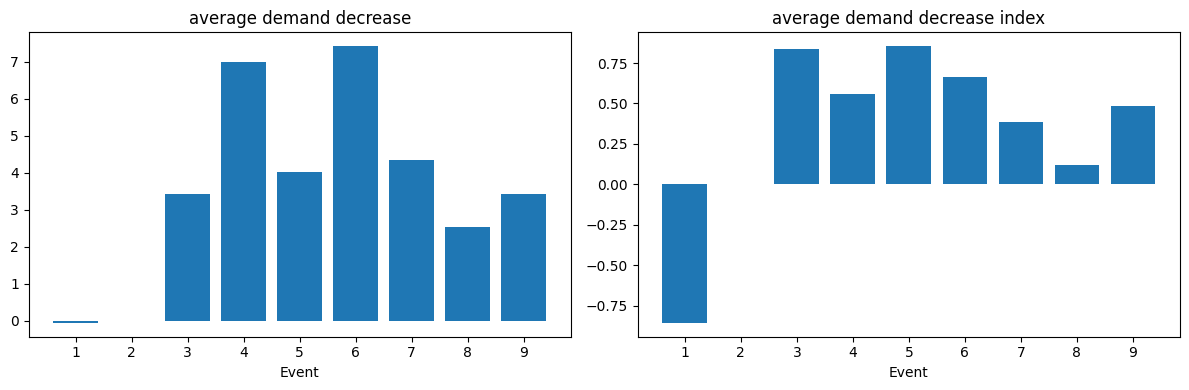

In [ ]:
import numpy as np

df_kpi = pd.read_csv(scenario_file_name)

# Create a dictionary to store the KPIs and their corresponding averages
kpi_averages = {}

# plot results
kpis = [v[0] for v in values_list_shed[0]]
#print(kpis)
column_count_limit = 2
row_count = math.ceil(len(kpis)/column_count_limit)
column_count = min(column_count_limit, len(kpis))
fig, _ = plt.subplots(row_count, column_count, figsize=(6*column_count, 4*row_count))
daily_avg_values = []
for ax in fig.axes[len(kpis):]:
    fig.delaxes(ax)

for i, (ax, kpi) in enumerate(zip(fig.axes, kpis)):
    values = [v[i][1] for v in values_list_shed]

    if isinstance(values[0], float):
        x = list(range(len(shed_signal_timestamps)))
        average = sum(values) / len(shed_signal_timestamps)
        print(f"The average for {kpi} is {average:.4f}")
        ax.bar(x, values)
        ax.set_xlabel('Event')

        kpi_averages[kpi] = average

         # Set custom x-labels
        x_labels = [str(i + 1) for i in range(len(x))]  # Generate labels from 1 to n
        ax.set_xticks(x)
        ax.set_xticklabels(x_labels)

     
    else:
        # calculate the average of the values
        avg_values = np.mean(values,axis=0)
        average = sum(avg_values) / len(avg_values)
        print(f"The average for {kpi} is {average:.2f}")
        
        kpi_averages[kpi] = average
        

        for j, v in enumerate(values):
            ax.plot(v, alpha=0.2)
        ax.plot(avg_values,label='Daily average', linewidth=2)
        ax.set_xlabel('Day')
        ax.legend(loc='upper left')  

           
    ax.set_title(kpi)


print(kpi_averages)

for kpi in list(kpi_averages.keys()):
    if kpi in df_kpi['kpi'].values:
        # Calculate the average value for the KPI
        average = kpi_averages[kpi]

        # Update the DataFrame with the average value for the specific bldg_identifier
        row_index = df_kpi[df_kpi['kpi'] == kpi].index[0]
        df_kpi.at[row_index, bldg_identifier] = average

# print(df_kpi)
# Save the updated DataFrame to the existing CSV file
df_kpi.to_csv(scenario_file_name, index=False)

plt.tight_layout()
plt.show()

In [ ]:
values_list_shift = []

for s, e in shift_signal_timestamps:
    values = []
    
    if load_shifting.AverageDemandIncrease.info()["name"] in suitable_kpis:
        # load_shifting
        values.append((
            load_shifting.AverageDemandIncrease.NAME,
            load_shifting.AverageDemandIncrease.calculate(
                data.baseline_electric_power_profile.tolist(),
                data.flexible_electric_power_profile.tolist(),
                generic_signal_start_timestamp=s,
                generic_signal_end_timestamp=e,
                timestamps=data.timestamp.tolist(),
        )))

    if load_shifting.AverageDemandIncreaseIntensity.info()["name"] in suitable_kpis:
        # load_shifting
        values.append((
            load_shifting.AverageDemandIncreaseIntensity.NAME,
            load_shifting.AverageDemandIncreaseIntensity.calculate(
                data.baseline_electric_power_profile.tolist(),
                data.flexible_electric_power_profile.tolist(),
                generic_signal_start_timestamp=s,
                generic_signal_end_timestamp=e,
                timestamps=data.timestamp.tolist(),
                #floor_area=floor_area,
        )))

    if load_shifting.AverageDemandIncreaseIndex.info()["name"] in suitable_kpis:
        # load_shifting
        values.append((
            load_shifting.AverageDemandIncreaseIndex.NAME,
            load_shifting.AverageDemandIncreaseIndex.calculate(
                data.baseline_electric_power_profile.tolist(),
                data.flexible_electric_power_profile.tolist(),
                generic_signal_start_timestamp=s,
                generic_signal_end_timestamp=e,
                timestamps=data.timestamp.tolist(),
        )))
    
    values_list_shift.append(values)

print(values_list_shift)

[[('average demand increase', 0.09501478579917), ('average demand increase index', 0.011756054398961213)], [('average demand increase', -4.949385531004605e-06), ('average demand increase index', -0.002519684161118363)], [('average demand increase', -3.508513631100615), ('average demand increase index', -0.23390323713771244)], [('average demand increase', -0.18526912451044697), ('average demand increase index', -0.0568317080730939)], [('average demand increase', -0.7943063624210532), ('average demand increase index', -0.13093914684373886)], [('average demand increase', 0.08504937361156406), ('average demand increase index', 0.005504314113219166)], [('average demand increase', -0.3368245346622243), ('average demand increase index', -0.044873086025752906)], [('average demand increase', 0.00034489509110479787), ('average demand increase index', 0.1689054184647263)], [('average demand increase', 1.966543536153691), ('average demand increase index', 0.2951536672366437)]]


The average for average demand increase is -0.2976
The average for average demand increase index is 0.0014
{'average demand increase': -0.2975517790471489, 'average demand increase index': 0.0013613991080148786}


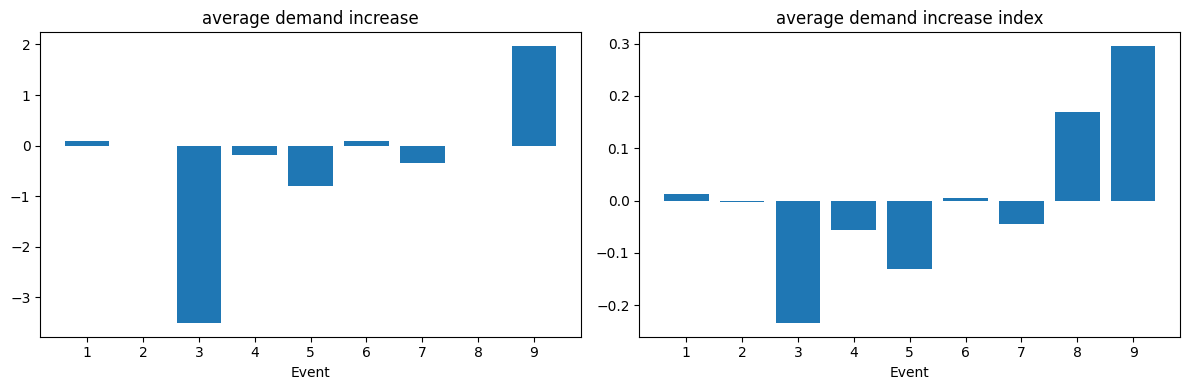

In [ ]:
import numpy as np

df_kpi = pd.read_csv(scenario_file_name)

# Create a dictionary to store the KPIs and their corresponding averages
kpi_averages = {}

# plot results
kpis = [v[0] for v in values_list_shift[0]]
#print(kpis)
column_count_limit = 2
row_count = math.ceil(len(kpis)/column_count_limit)
column_count = min(column_count_limit, len(kpis))
fig, _ = plt.subplots(row_count, column_count, figsize=(6*column_count, 4*row_count))
daily_avg_values = []
for ax in fig.axes[len(kpis):]:
    fig.delaxes(ax)

for i, (ax, kpi) in enumerate(zip(fig.axes, kpis)):
    values = [v[i][1] for v in values_list_shift]

    if isinstance(values[0], float):
        x = list(range(len(shift_signal_timestamps)))
        average = sum(values) / len(shift_signal_timestamps)
        print(f"The average for {kpi} is {average:.4f}")
        ax.bar(x, values)
        ax.set_xlabel('Event')

        kpi_averages[kpi] = average

         # Set custom x-labels
        x_labels = [str(i + 1) for i in range(len(x))]  # Generate labels from 1 to n
        ax.set_xticks(x)
        ax.set_xticklabels(x_labels)

     
    else:
        # calculate the average of the values
        avg_values = np.mean(values,axis=0)
        average = sum(avg_values) / len(avg_values)
        print(f"The average for {kpi} is {average:.2f}")
        
        kpi_averages[kpi] = average
        

        for j, v in enumerate(values):
            ax.plot(v, alpha=0.2)
        ax.plot(avg_values,label='Daily average', linewidth=2)
        ax.set_xlabel('Day')
        ax.legend(loc='upper left')  

           
    ax.set_title(kpi)


print(kpi_averages)

for kpi in list(kpi_averages.keys()):
    if kpi in df_kpi['kpi'].values:
        # Calculate the average value for the KPI
        average = kpi_averages[kpi]

        # Update the DataFrame with the average value for the specific bldg_identifier
        row_index = df_kpi[df_kpi['kpi'] == kpi].index[0]
        df_kpi.at[row_index, bldg_identifier] = average

# print(df_kpi)
# Save the updated DataFrame to the existing CSV file
df_kpi.to_csv(scenario_file_name, index=False)

plt.tight_layout()
plt.show()

In [ ]:
values_list_rebound = []

for s, e in rebound_signal_timestamps:
    values = []

    if peak_power_or_energy_rebound.AveragePowerRebound.info()["name"] in suitable_kpis:
        # peak_power_or_energy_rebound
        values.append((
            peak_power_or_energy_rebound.AveragePowerRebound.NAME,
            peak_power_or_energy_rebound.AveragePowerRebound.calculate(
                data.baseline_electric_power_profile.tolist(),
                data.flexible_electric_power_profile.tolist(),
                generic_signal_start_timestamp=s,
                generic_signal_end_timestamp=e,
                timestamps=data.timestamp.tolist(),
        )))
   
    if peak_power_or_energy_rebound.AveragePowerReboundIndex.info()["name"] in suitable_kpis:
        # peak_power_or_energy_rebound
        values.append((
            peak_power_or_energy_rebound.AveragePowerReboundIndex.NAME,
            peak_power_or_energy_rebound.AveragePowerReboundIndex.calculate(
                data.baseline_electric_power_profile.tolist(),
                data.flexible_electric_power_profile.tolist(),
                generic_signal_start_timestamp=s,
                generic_signal_end_timestamp=e,
                timestamps=data.timestamp.tolist(),
        )))
    values_list_rebound.append(values)


print(values_list_rebound)

[[('average power rebound', -4.949385531004605e-06), ('average power rebound index', -0.002519684161118363)], [('average power rebound', -4.881058126372947e-06), ('average power rebound index', -0.002511893280694233)], [('average power rebound', -0.00012981669849770907), ('average power rebound index', -0.07359222869338333)], [('average power rebound', -2.3605610735634177), ('average power rebound index', -0.2684675013372877)], [('average power rebound', 0.0002897592502657595), ('average power rebound index', 0.14905734662854542)], [('average power rebound', 0.0004056724719711086), ('average power rebound index', 0.18998411793789072)], [('average power rebound', 0.00031603892223497874), ('average power rebound index', 0.1682079739331912)], [('average power rebound', 1.3052573683144955), ('average power rebound index', 0.18619232337022562)], [('average power rebound', 0.0002824012960850362), ('average power rebound index', 0.12178998431556143)]]


The average for average power rebound is -0.1171
The average for average power rebound index is 0.0520


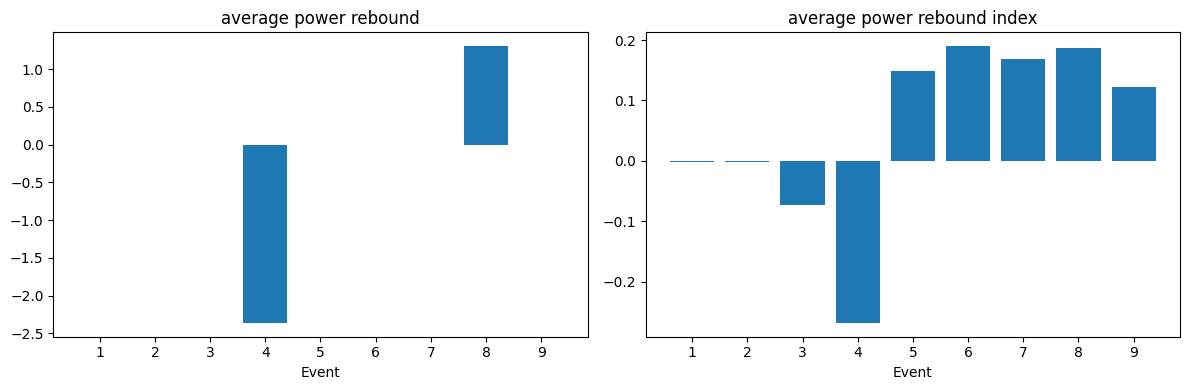

{'average power rebound': -0.11712772005005784, 'average power rebound index': 0.05201560430143675}


<Figure size 640x480 with 0 Axes>

In [ ]:
import numpy as np

df_kpi = pd.read_csv(scenario_file_name)

# Create a dictionary to store the KPIs and their corresponding averages
kpi_averages = {}

# plot results
kpis = [v[0] for v in values_list_rebound[0]]
#print(kpis)
column_count_limit = 2
row_count = math.ceil(len(kpis)/column_count_limit)
column_count = min(column_count_limit, len(kpis))
fig, _ = plt.subplots(row_count, column_count, figsize=(6*column_count, 4*row_count))
daily_avg_values = []
for ax in fig.axes[len(kpis):]:
    fig.delaxes(ax)

for i, (ax, kpi) in enumerate(zip(fig.axes, kpis)):
    values = [v[i][1] for v in values_list_rebound]

    if isinstance(values[0], float):
        x = list(range(len(rebound_signal_timestamps)))
        average = sum(values) / len(rebound_signal_timestamps)
        print(f"The average for {kpi} is {average:.4f}")
        ax.bar(x, values)
        ax.set_xlabel('Event')

        kpi_averages[kpi] = average

         # Set custom x-labels
        x_labels = [str(i + 1) for i in range(len(x))]  # Generate labels from 1 to n
        ax.set_xticks(x)
        ax.set_xticklabels(x_labels)

     
    else:
        # calculate the average of the values
        avg_values = np.mean(values,axis=0)
        average = sum(avg_values) / len(avg_values)
        print(f"The average for {kpi} is {average:.2f}")
        
        kpi_averages[kpi] = average
        

        for j, v in enumerate(values):
            ax.plot(v, alpha=0.2)
        ax.plot(avg_values,label='Daily average', linewidth=2)
        ax.set_xlabel('Day')
        ax.legend(loc='upper left')  

           
    ax.set_title(kpi)

plt.tight_layout()
plt.show()

print(kpi_averages)

for kpi in list(kpi_averages.keys()):
    if kpi in df_kpi['kpi'].values:
        # Calculate the average value for the KPI
        average = kpi_averages[kpi]

        # Update the DataFrame with the average value for the specific bldg_identifier
        row_index = df_kpi[df_kpi['kpi'] == kpi].index[0]
        df_kpi.at[row_index, bldg_identifier] = average

plt.tight_layout()
plt.show()

# Save the updated DataFrame to the existing CSV file
df_kpi.to_csv(scenario_file_name, index=False)

In [ ]:
values_list_evaluation = []

for s, e in evaluation_timestamps:
    
    values = []
    
    if demand_response_costs_or_savings.FlexibilitySavingsIndex.info()["name"] in suitable_kpis:
        # demand_response_costs_or_savings
        values.append((
            demand_response_costs_or_savings.FlexibilitySavingsIndex.NAME,
            demand_response_costs_or_savings.FlexibilitySavingsIndex.calculate(
                data_price_merge.baseline_cost_profile.tolist(),
                data_price_merge.flexible_cost_profile.tolist(),
                timestamps=data_price_merge.timestamp.tolist(),
                evaluation_start_timestamp=s,
                evaluation_end_timestamp=e,
        )))
    
    
    if demand_response_energy_efficiency.EnergySavingsOfDemandResponse.info()["name"] in suitable_kpis:
        # demand_response_energy_efficiency
        values.append((
            demand_response_energy_efficiency.EnergySavingsOfDemandResponse.NAME,
            demand_response_energy_efficiency.EnergySavingsOfDemandResponse.calculate(
                data.baseline_electric_power_profile.tolist(),
                data.flexible_electric_power_profile.tolist(),
                timestamps=data.timestamp.tolist(),
                evaluation_start_timestamp=s,
                evaluation_end_timestamp=e,
        )))

    
    if demand_response_energy_efficiency.NetBuildingConsumptionChangePercentage.info()["name"] in suitable_kpis:
        # demand_response_energy_efficiency
        values.append((
            demand_response_energy_efficiency.NetBuildingConsumptionChangePercentage.NAME,
            demand_response_energy_efficiency.NetBuildingConsumptionChangePercentage.calculate(
                data.baseline_electric_power_profile.tolist(),
                data.flexible_electric_power_profile.tolist(),
                timestamps=data.timestamp.tolist(),
                evaluation_start_timestamp=s,
                evaluation_end_timestamp=e,
        )))


    if peak_power_shedding.PeakPowerReduction.info()["name"] in suitable_kpis:
        # Peak power shedding
        values.append((
            peak_power_shedding.PeakPowerReduction.NAME, 
            peak_power_shedding.PeakPowerReduction.calculate(
                data.baseline_electric_power_profile.tolist(),
                data.flexible_electric_power_profile.tolist(),
                timestamps=data.timestamp.tolist(),
                evaluation_start_timestamp=s,
                evaluation_end_timestamp=e,
        )))


    values_list_evaluation.append(values)
print(values_list_evaluation)

[[('flexibility savings index', 0.13279821434080152), ('energy savings of demand response', 337.3389319390227), ('net building consumption change percentage', -11.453106141371586), ('peak power reduction', 2.539373065111839)]]


The average for flexibility savings index is 0.1328
The average for energy savings of demand response is 337.3389
The average for net building consumption change percentage is -11.4531
The average for peak power reduction is 2.5394


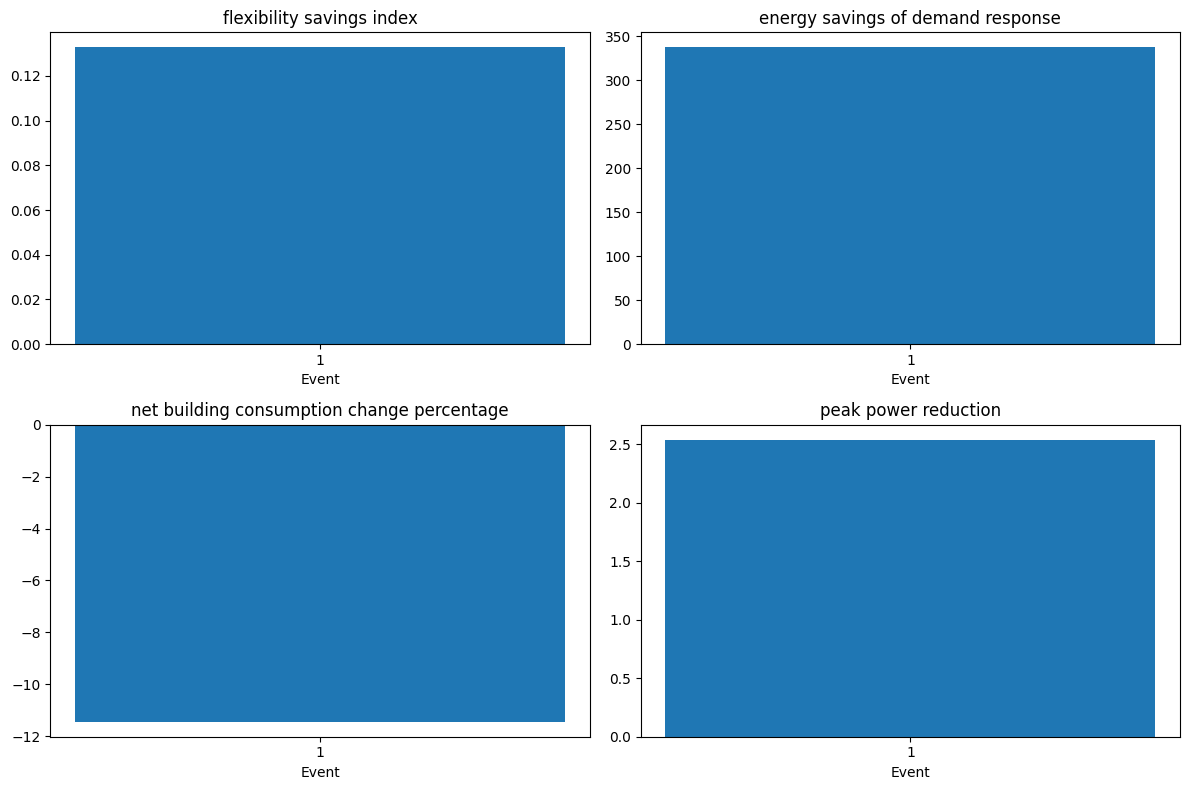

{'flexibility savings index': 0.13279821434080152, 'energy savings of demand response': 337.3389319390227, 'net building consumption change percentage': -11.453106141371586, 'peak power reduction': 2.539373065111839}


<Figure size 640x480 with 0 Axes>

                                           kpi    bestest_air  \
0                      average demand decrease   1.356122e-02   
1            average demand decrease intensity   2.825254e-04   
2                average demand decrease index   4.845862e-01   
3            energy savings of demand response   1.112046e+00   
4   net building consumption change percentage  -1.000518e+01   
5                      average demand increase  -5.198277e-04   
6            average demand increase intensity  -1.082974e-05   
7                average demand increase index   1.168426e-01   
8                    flexibility savings index   1.640940e-01   
9        cumulative average thermal discomfort            NaN   
10                       average power rebound   1.219071e-04   
11                 average power rebound index  8.739053e+131   
12                        peak power reduction  -6.839173e-02   

    multizone_office_simple_air  
0                      3.568064  
1                    

In [ ]:
import numpy as np

df_kpi = pd.read_csv(scenario_file_name)

# Create a dictionary to store the KPIs and their corresponding averages
kpi_averages = {}

# plot results
kpis = [v[0] for v in values_list_evaluation[0]]
#print(kpis)
column_count_limit = 2
row_count = math.ceil(len(kpis)/column_count_limit)
column_count = min(column_count_limit, len(kpis))
fig, _ = plt.subplots(row_count, column_count, figsize=(6*column_count, 4*row_count))
daily_avg_values = []
for ax in fig.axes[len(kpis):]:
    fig.delaxes(ax)

for i, (ax, kpi) in enumerate(zip(fig.axes, kpis)):
    values = [v[i][1] for v in values_list_evaluation]

    if isinstance(values[0], float):
        x = list(range(len(evaluation_timestamps)))
        average = sum(values) / len(evaluation_timestamps)
        print(f"The average for {kpi} is {average:.4f}")
        ax.bar(x, values)
        ax.set_xlabel('Event')

        kpi_averages[kpi] = average

         # Set custom x-labels
        x_labels = [str(i + 1) for i in range(len(x))]  # Generate labels from 1 to n
        ax.set_xticks(x)
        ax.set_xticklabels(x_labels)

     
    else:
        # calculate the average of the values
        avg_values = np.mean(values,axis=0)
        average = sum(avg_values) / len(avg_values)
        print(f"The average for {kpi} is {average:.2f}")
        
        kpi_averages[kpi] = average
        

        for j, v in enumerate(values):
            ax.plot(v, alpha=0.2)
        ax.plot(avg_values,label='Event average', linewidth=2)
        ax.set_xlabel('Event')
        ax.legend(loc='upper left')  

           
    ax.set_title(kpi)

plt.tight_layout()
plt.show()

print(kpi_averages)

for kpi in list(kpi_averages.keys()):
    if kpi in df_kpi['kpi'].values:
        # Calculate the average value for the KPI
        average = kpi_averages[kpi]

        # Update the DataFrame with the average value for the specific bldg_identifier
        row_index = df_kpi[df_kpi['kpi'] == kpi].index[0]
        df_kpi.at[row_index, bldg_identifier] = average

plt.tight_layout()
plt.show()

print(df_kpi)
# Save the updated DataFrame to the existing CSV file
df_kpi.to_csv(scenario_file_name, index=False)